# Agents with Human-in-the-Loop

前面的章节中，我们首先使用 langgraph 创建了一个邮件助手（email assistant），该助手有一个分类路由模块（triage router）和一个邮件回复模块（response agent）。紧接着，我们通过精心设计的测试用例对每个单独模块进行了单元测试，也对整个邮件助手进行了端到端测试。

也许测试完成后，email assistant 的效果很好，但是面对邮件处理这样一项如此重要的任务，我们真的敢完全交给 AI 来自动处理吗？这个答案应该是否定的，人应该参与到这个事情的处理进程中来。

下图是整个 Agent 的流程图，接下来我们要实现的功能就是图中高亮的部分 **人类反馈（Human Feedback）** 模块。
![HITL overview ](img/overview_hitl.png)

## Human in the Loop
Human-in-the-loop (HITL）是早些年提出的一个机器学习领域用于人机协同的概念，Google Cloud 提供了关于 HITL 的解释：
> 人机协同 (HITL) 机器学习是一种协作方法，它将人类输入和专业知识融入到机器学习 (ML) 和人工智能系统的生命周期中。人类参与机器学习模型的训练、评估或运行，提供有价值的指导、反馈和注释。通过这种协作，HITL 旨在结合人类和机器的独特优势，提高机器学习系统的准确性、可靠性和适应性。

LangGraph 框架提供了对 Human-in-the-loop 理念的支持，通过中断（Interrupt）和持久化（Persistence）功能，可以让我们在任务执行过程中，适时的中断任务，等待人类的反馈，然后根据人类的反馈来决定下一步的任务执行。


## Adding HITL to out email assistant

接下来，我们将会把 HITL 的能力加入到 agent 中。下图具体展示了需要用户提供反馈的节点：
1. 对于通知类的邮件，在结束任务之前，需要确保用户已经收到通知并反馈下一步的操作；
2. 对于需要回复的邮件，需要在发送邮件之前，让用户确认邮件内容是否需要调整。

![HITL 示意图](img/hitl_schematic.png)

In [1]:
from dotenv import load_dotenv
load_dotenv("../.env")
import os
import sys
sys.path.append("..")

### Tools
像之前的所有章节一样，我们需要先定义出所有能用的工具，因为这限定了 agent 的能力范围。

不同的是，这里会比之前的邮件助手多定义一个 `Question` 工具，这个工具可以让 agent 向用户提问。

In [2]:
from typing import Literal
from datetime import datetime
from pydantic import BaseModel

from langchain.chat_models import init_chat_model
from langchain.tools import tool

from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt

from src.prompts import (triage_system_prompt, triage_user_prompt,
                         default_triage_instructions,
                         agent_system_prompt_hitl, default_background,
                         default_response_preferences, default_cal_preferences)
from src.tools.default.prompt_templates import HITL_TOOLS_PROMPT
from src.schemas import State, RouterSchema, StateInput
from src.utils import parse_email, format_for_display, format_email_markdown

In [3]:
from rich.markdown import Markdown
Markdown(HITL_TOOLS_PROMPT)

 1 write_email(to, subject, content) - Send emails to specified recipients                                         
 2 schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - Schedule calendar meetings  
   where preferred_day is a datetime object                                                                        
 3 check_calendar_availability(day) - Check available time slots for a given day                                   
 4 Question(content) - Ask the user any follow-up questions                                                        
 5 Done - E-mail has been sent

`HITL_TOOLS_PROMPT` 中说明了 agent 需要的5个工具，下面的代码将具体定义他们。

In [4]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"Meeting '{subject}' scheduled on {date_str} at {start_time} for {duration_minutes} minutes with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

@tool
# This is new! 
class Question(BaseModel):
      """Question to ask user."""
      content: str
    
@tool
class Done(BaseModel):
      """E-mail has been sent."""
      done: bool

tools = [
    write_email,
    schedule_meeting,
    check_calendar_availability,
    Question,
    Done,
]

tools_by_name = {tool.name: tool for tool in tools}

这里再重点介绍一下 `write_email` 这个工具，之前因为这个名字的原因，总是误解它的作用，以为它是用来写邮件的，其实是有点绕的。

`write_email` 的的真正作用是发送邮件，如果 agent 想要发送邮件，就要调用这个工具，如果要调用这个工具，就必须给出工具所需的参数。

再看参数是什么：
- to: 收件人
- subject: 邮件主题
- content: 邮件内容

也就是说，如果 agent 要发送邮件，就必须给出收件人、邮件主题和邮件内容。 LLM 在处理的时候，就会根据输入的邮件内容，生成这三个参数，其中包含“邮件内容”，这也就是真正写邮件的地方。

`write_email` 虽然是用来发送邮件的，但同时也是，在使用它的过程中，让 LLM “写”出来了邮件的内容，所以，这个工具的名字就定义为了 `write_email`，它的作用就是写邮件并发送。

接着，再回顾一下之前定义的 response agent 的工作流程：
1. `triage_router` 将分类为 `respond` 的邮件，交给 `response_agent` 处理，同时会在历史对话中，添加一条用户消息，用于提示 llm 回复邮件
2. `response_agent` 中的 `llm_call` 节点，根据上一条用户消息，查看工具列表，发现需要调用 `write_email` 工具来处理用户的需求
3. `llm_call` 生成工具所需的参数，其中包含邮件的内容（也就是写邮件的过程）
4. 参数生成完毕后，`llm_call` 返回一个 tool call， tool name 为 `write_email`，tool args 包含邮件的收件人、主题和内容

### LLMs
初始化两个 LLMs，一个用于 triage router（通过 `RouterSchema` 格式化了输出），一个用于 response agent（添加了工具调用）。

我们为两个 llm 选择了相同的模型，实际的项目中，可以根据效果、速度、成本等几个因素，选择不同的模型。

In [5]:
model_name = os.getenv("OPENAI_MODEL")
model_provider = os.getenv("MODEL_PROVIDER")

llm = init_chat_model(model_name, model_provider=model_provider, temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema)

llm = init_chat_model(model_name, model_provider=model_provider, temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="required", parallel_tool_calls=False)

### Triage Node
邮件分类节点（Triage node）就像我们之前实现的那样，负责分析邮件内容，决定邮件应该如何处理。与之前不同的是，对于分类为 `notify` 的邮件，我们需要中断 graph 的执行，允许用户来查看邮件内容。

所以，在 triage node 之后，会加入一个新的节点 `triage_interrupt_node` 。

In [6]:
def triage_router(
    state: State,
) -> Command[Literal["triage_interrupt_handler", "response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])
    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    # Create email markdown for Agent Inbox in case of notification
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Format system prompt with backgroud and triage instructions
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions,
    )

    # Run the router LLM
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    # Decision
    classification = result.classification

    # Process the classifiction decision
    if classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        # Next node
        goto = "response_agent"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{email_markdown}",
                }
            ],
        }
    elif classification == "ignore":
        print("📧 Classification: IGNORE - This email does not require a response")
        # Next node
        goto = "__end__"
        # Update the state
        update = {
            "classification_decision": result.classification,
            "messages": [
                {
                    "role": "user",
                    "content": f"Ignore the email: \n\n{email_markdown}",
                }
            ],
        }
    elif classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        # This is NEW!
        goto = "triage_interrupt_handler"
        # Update the state
        update = {
            "classification_decision": result.classification,
        }
    else:
        raise ValueError(f"Invalid classification: {classification}")
    return Command(goto=goto, update=update)

### Triage Interrupt Handler

如果邮件的分类是 `notify`, 我们就中断 graph ，如下图左边绿色部分所示，中断之后，用户可以根据实际情况选择 `ignore` 或者 `respond`。
![overview](img/HITL_flow_triage.png)

为此，graph 中会加入一个新的 node，`triage_interrupt_handler`，它将会：
1. 如果分类的结果是 `notify`, 将会中断，并将一个包含分类结果的 `dict` 展示给用户；
2. 用户可以根据实际的邮件内容做出回应。

为了使用好这些功能，LangChain 团队开发了 Agent Inbox，直译过来是智能体收件箱，用户所有需要与 agent 进行沟通的事情都会在这个收件箱中，方便用户统一追踪任何未完成的操作。部署的部分会介绍 Agent Inbox 的使用方法。

In [ ]:
def triage_interrupt_handler(
    state: State,
) -> Command[Literal["response_agent", "__end__"]]:
    """Handles interrupts from the triage step."""

    # Parse the email input
    author, to, subject, email_thread = parse_email(state["email_input"])

    # Create email markdown for Agent Inbox in case of notification
    email_markdown = format_email_markdown(subject, author, to, email_thread)

    # Create messages
    messages = [
        {"role": "user", "content": f"Email to notify user about: {email_markdown}"}
    ]

    # Create interrupt that is shown to the user
    request = {
        "action_request": {
            "action": f"Email Assistant: {state['classification_decision']}",
            "args": {},
        },
        "config": {
            "allow_ignore": True,
            "allow_respond": True,
            "allow_edit": False,
            "allow_accept": False,
        },
        # Email to show in the agent inbox
        "description": email_markdown,
    }

    responses = interrupt([request])

    # Agent Inbox responds with a list of dicts with a single key `type`,
    # which can be `accept`, `edit`, `ignore`, or `response`.
    response = responses[0]

    # If you provide feedback, go to reponse agent and use feedbock to respond to email
    if response["type"] == "response":
        # Add feedback to the message
        user_input = response["args"]
        # Used by the response agent
        messages.append(
            {
                "role": "user",
                "content": f"User wants to reply to the email. Use this feedback to respond: {user_input}",
            }
        )
        # Go to response agent
        goto = "response_agent"
    # If you ignore, go to end
    elif response["type"] == "ignore":
        goto = END
    # Catch all other responses
    else:
        raise ValueError(f"Invalid response: {response}")

    # Update the state
    update = {
        "messages": messages,
    }
    return Command(goto=goto, update=update)

上面便是这个新增加的 node 的代码，需要重点解释一下：
- `interrupt()` 函数，通过暂停（pause） graph 的执行，来实现 HITL 的功能；
- 暂停之后，用户需要在客户端执行相应的操作，才能继续 graph 的执行，这里的客户端可以是 Agent Inbox，也可以使用 `Command(resume=xxx)` 模拟的客户端；
- 要使用 `interrupt()` 函数，需要在 graph 的编译时，指定 `checkpointer`，这样才能保存当前的状态，实现暂停和恢复的功能。


### Response Agent with Interrupts

Response agent 也需要加入中断功能，以允许用户在邮件回复生成后提供反馈。

#### LLM call

Response agent 中的 llm call 和往期教程中设计的一样，调用定义好的工具来完成邮件的处理任务。

In [8]:
def llm_call(state: State):
    """LLM decides whether call a tool or not."""

    input_messages = [{
        "role": "system",
        "content": agent_system_prompt_hitl.format(
            tools_prompt=HITL_TOOLS_PROMPT,
            background=default_background,
            response_preferences=default_response_preferences, 
            cal_preferences=default_cal_preferences)
    }] + state["messages"]

    return {"messages": [llm_with_tools.invoke(input_messages)]}

**重点强调**：`agent_system_prompt_hitl` 是非常重要的提示词，它需要详细描述当前 agent 所处理的事件的详细处理过程，建议这个 prompt 要有当前领域专业的人士来参与指导。包含处理的流程，所需的工具等等。

```text
< Instructions >
When handling emails, follow these steps:
1. Carefully analyze the email content and purpose
2. IMPORTANT --- always call a tool and call one tool at a time until the task is complete: 
3. If the incoming email asks the user a direct question and you do not have context to answer the question, use the Question tool to ask the user for the answer
4. For responding to the email, draft a response email with the write_email tool
5. For meeting requests, use the check_calendar_availability tool to find open time slots
6. To schedule a meeting, use the schedule_meeting tool with a datetime object for the preferred_day parameter
   - Today's date is """ + datetime.now().strftime("%Y-%m-%d") + """ - use this for scheduling meetings accurately
7. If you scheduled a meeting, then draft a short response email using the write_email tool
8. After using the write_email tool, the task is complete
9. If you have sent the email, then use the Done tool to indicate that the task is complete
</ Instructions >
```

看完上面的 prompt 不难发现，**其实在未深入研究 agent 之前，单纯从实现方案上来谈，很多事想想都是蛮简单的。但是，深入了解了具体的实现过程之后，才知道，再容易的方案，也是由细节支撑起来的，绝不是想想那么简单，任何一个处理步骤都应该有明确的指示。 LLM 确实可以做很多事情，帮你做很多决定，但是，做事的原则，你必须跟它讲清楚，而且这个原则必须是符合当前任务所处的领域的，不能是想当然的瞎指挥。**

#### Interrupt Handler

`interrupt_handler` 是 response agent 实现 HITL 功能的核心组件。

它的作用是检查 LLM 想要执行的工具调用，以及确定哪些工具执行前需要用户确认。具体工作内容如下：
1. Tool Selection: `interrupt_handler` 维护了一份需要用户批准才能执行的 **HITL Tools**，包含3个工具：
    - `write_email`: 发送邮件是一件很重要的事，需要用户确认
    - `schedule_meeting`: 安排会议会影响用户日程，同样需要用户确认
    - `Question`: 向用户提问需要与用户直接交互（direct interaction）
2. Direct Execution: 不在 **HITL Tools** 里的工具（比如 `check_calendar_availability`）可以直接执行，不需要用户确认；
3. Context Preparation: 对于那些需要用户确认的工具，`interrupt_handler` 会做一些准备工作，方便用户更好的了解上下文情况：
    - 将原始的邮件内容作为上下文
    - 格式化好工具调用的内容方便用户查阅
    - 针对每种工具类型，配置好哪些交互方式是允许的
4. Interrupt Creation: 根据上述信息，创建中断请求：
    - 请求操作的名称和参数
    - 配置好的允许的交互类型
    - 一份包含原始邮件和建议工具调用内容的详细描述
5. Response Processing: 中断结束之后，`iterrupt_handler` 处理用户的回应：
    - Accept: 用原始的参数执行工具调用；
    - Edit: 用修改后的参数执行工具调用；
    - Ignore: 取消工具调用；
    - Response: 记录下当前行为，并且不进行工具调用。

`interrupt_handler` 保证用户对所用重要操作都能参与其中，同时，对于一些不重要的操作，也能自动执行。

为了能精确控制 agent 的行为，用户也可以修改 HITL 工具的参数，比如要发送的邮件内容。

整个流程如下图所示：

![邮件助手 agent 流程图](img/HITL_flow.png)

In [9]:
def interrupt_handler(state: State) -> Command[Literal["llm_call", "__end__"]]:
    """Creates an interrupt fro human review of tool calls"""

    # Store messages
    result = []

    # Go to the LLM call node next
    goto = "llm_call"

    # Allowed tools for HITL
    hitl_tools = ["write_email", "schedule_meeting", "Question"]

    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:

        # If tool is not in our HITL Tools list, execute it directly without interruption
        if tool_call["name"] not in hitl_tools:

            # Execute tool without iterruption
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(
                {
                    "role": "tool",
                    "content": observation,
                    "tool_call_id": tool_call["id"],
                }
            )
            continue

        # Get original email from email_input in state
        email_input = state["email_input"]
        author, to, subject, email_thread = parse_email(email_input)
        original_email_markdown = format_email_markdown(
            subject, author, to, email_thread
        )

        # Format tool call for display and prepend the original email
        tool_display = format_for_display(tool_call)
        description = original_email_markdown + tool_display

        # Configure what actions are allowed in Agent Inbox
        if tool_call["name"] == "write_email":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "schedule_meeting":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": True,
                "allow_accept": True,
            }
        elif tool_call["name"] == "Question":
            config = {
                "allow_ignore": True,
                "allow_respond": True,
                "allow_edit": False,
                "allow_accept": False,
            }
        else:
            raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Create the interrupt request
        request = {
            "action_request": {"action": tool_call["name"], "args": tool_call["args"]},
            "config": config,
            "description": description,
        }

        # Send to Agent Inbox and wait for response
        response = interrupt([request])[0]

        # Handle the response
        if response["type"] == "accept":

            # Execute the tool with original args
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(
                {
                    "role": "tool",
                    "content": observation,
                    "tool_call_id": tool_call["id"],
                }
            )
        elif response["type"] == "edit":

            # Tool selection
            tool = tools_by_name[tool_call["name"]]

            # Get edited args from Agent Inbox
            edited_args = response["args"]["args"]

            # Update the AI message's tool call with edited content (reference to the message in the state)
            ai_message = state["messages"][-1]  # Get the most recent message from state
            current_id = tool_call["id"]  # Store the ID of the tool call being edited

            # Create a new list of tool calls by filtering out the one being edited and adding the updated version
            # This avoids modifying the original list directly (immutable approach)
            updated_tool_calls = [
                tc for tc in ai_message.tool_calls if tc["id"] != current_id
            ] + [
                {
                    "type": "tool_call",
                    "name": tool_call["name"],
                    "args": edited_args,
                    "id": current_id,
                }
            ]

            # Create a new copy of the message with updated tool calls rather than modifying the original
            # This ensures state immutability and prevents side effects in other parts of the code
            # When we update the messages state key ("messages": result), the add_messages reducer will
            # overwrite existing messages by id and we take advantage of this here to update the tool calls
            result.append(
                ai_message.model_copy(update={"tool_calls": updated_tool_calls})
            )

            # Update the write_email tool call with the edited content from Agent Inbox
            if tool_call["name"] == "write_email":

                # Execute the tool with edited args
                observation = tool.invoke(edited_args)

                # Add only the tool response message
                result.append(
                    {"role": "tool", "content": observation, "tool_call_id": current_id}
                )

            # Update the schedule_meeting tool call with the edited content from Agent Inbox
            elif tool_call["name"] == "schedule_meeting":
                # Execute the tool with edited args
                observation = tool.invoke(edited_args)

                # Add only the tool response message
                result.append(
                    {"role": "tool", "content": observation, "tool_call_id": current_id}
                )

            # Catch all other tool calls
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "ignore":
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and tell the agent how to proceed
                result.append(
                    {
                        "role": "tool",
                        "content": "User ignored this email draft. Ignore this email and end the workflow.",
                        "tool_call_id": tool_call["id"],
                    }
                )
                # Go to end
                goto = END
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and tell the agent how to proceed
                result.append(
                    {
                        "role": "tool",
                        "content": "User ignored this calendar meeting draft. Ignore this email and end the workflow.",
                        "tool_call_id": tool_call["id"],
                    }
                )
                # Go to end
                goto = END
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and tell the agent how to proceed
                result.append(
                    {
                        "role": "tool",
                        "content": "User ignored this question. Ignore this email and end the workflow.",
                        "tool_call_id": tool_call["id"],
                    }
                )
                # Go to end
                goto = END
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        elif response["type"] == "response":
            # User provided feedback
            user_feedback = response["args"]
            if tool_call["name"] == "write_email":
                # Don't execute the tool, and add a message with user feedback to incorporate into the email
                result.append(
                    {
                        "role": "tool",
                        "content": f"User gave feedback, which can we incorporate into the email. Feedback: {user_feedback}",
                        "tool_call_id": tool_call["id"],
                    }
                )
            elif tool_call["name"] == "schedule_meeting":
                # Don't execute the tool, and add a message with user feedback to incorporate into the email
                result.append(
                    {
                        "role": "tool",
                        "content": f"User gave feedback, which can we incorporate into the meeting request. Feedback: {user_feedback}",
                        "tool_call_id": tool_call["id"],
                    }
                )
            elif tool_call["name"] == "Question":
                # Don't execute the tool, and add a message with user feedback to incorporate into the email
                result.append(
                    {
                        "role": "tool",
                        "content": f"User gave feedback, which can we can use for any follow up actions. Feedback: {user_feedback}",
                        "tool_call_id": tool_call["id"],
                    }
                )
            else:
                raise ValueError(f"Invalid tool call: {tool_call['name']}")

        # Catch all other responses
        else:
            raise ValueError(f"Invalid response: {response}")

    # Update the state
    update = {
        "messages": result,
    }

    return Command(goto=goto, update=update)

Compile the graph

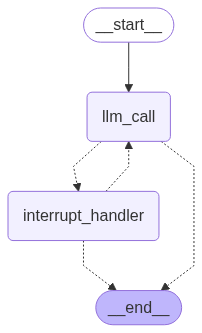

In [10]:
from src.utils import show_graph

# Conditional edge function
def should_continue(state: State) -> Literal["interrupt_handler", "__end__"]:
    """Router to tool handler, or end if Done tool called"""

    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "Done":
                return END
            else:
                return "interrupt_handler"

# Build workflow of response agent
agent_builder = StateGraph(State)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("interrupt_handler", interrupt_handler)

# Add edges
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, {
    "interrupt_handler": "interrupt_handler",
    END: END,
})

# Compile the response agent
response_agent = agent_builder.compile()
show_graph(response_agent)


构建完整的邮件助手，将 `triage_router`、`triage_interrupt_handler`、`response_agent` 三个节点串联起来

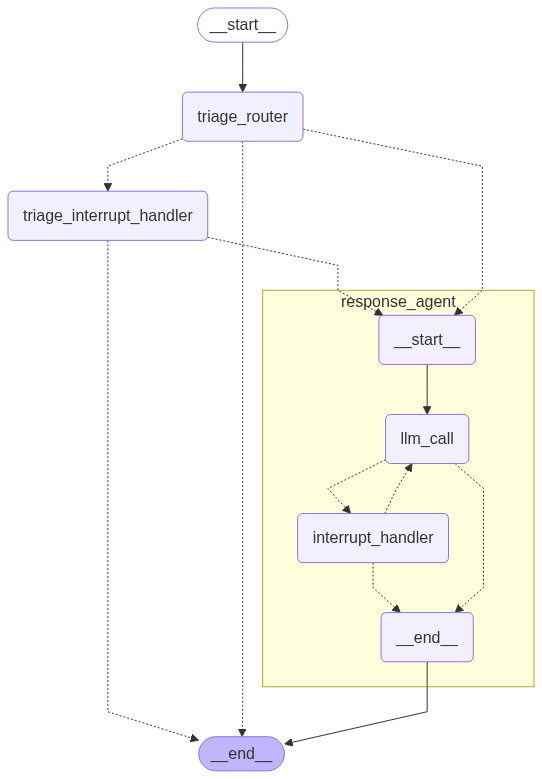

In [11]:
# Build overall workflow
overall_workflow = (
    StateGraph(State, input=StateInput)
    .add_node(triage_router)
    .add_node(triage_interrupt_handler)
    .add_node("response_agent", response_agent)
    .add_edge(START, "triage_router")
)

email_assistant = overall_workflow.compile()
show_graph(email_assistant, xray=True)

## HITL 运行逻辑详解

回顾一下邮件助手中所有需要人类用户参与的情况：

**Triage Interruption** 当一封输入邮件被分类为 "notify" 时，系统会中断，并将邮件内容展示给用户
- 用户决策：用户可以选择忽略（ignore）这个通知，或者提供反馈意见然后回复邮件
- 流程控制：如果忽略，流程结束；如果提供反馈，流程继续，进入 Response Agent

**Write Email** 在执行 `write_email` 工具前，系统将 LLM 起草好的邮件（工具所需参数）展示给用户检查
- 用户决策和流程控制：忽略（ignore）后结束流程，接受（accept）后继续执行，编辑（edit）参数后继续执行工具，或者提供反馈意见（response）重新进入 LLM 节点

**Schedule Meeting**  执行 `schedule_meeting` 工具前，系统将把会议的细节展示给用户确认
- 用户决策和流程控制：忽略（ignore）后结束流程，接受（accept）后继续执行，编辑（edit）参数后继续执行工具，或者提供反馈意见（response）重新进入 LLM 节点

**Question** 系统向用户提问以获取更多信息
- 用户决策和流程控制：忽略（ignore）后结束流程，或者提供反馈意见（response）后重新进入 LLM 节点

接下来，详细演示一下用户应该怎样执行这些操作。

### Review and Accept

Interrupt 允许用户检查并接受 agent 的决策，用户批准后，可直接执行工具调用。

In [12]:
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command

In [16]:
# Email to respond to
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with checkpointer
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_1 = uuid.uuid4()
thread_config_1 = {"configurable": {"thread_id": thread_id_1}}

# Run the graph until a tool call that we choose to interrupt
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 45, 'preferred_day': '2025-07-15T14:00:00', 'start_time': 14}}


- 上面的代码定义了一封邮件用于模拟 accept 的场景；
- 使用 `InMemorySaver` 来进行持久化，`interrupt` 实现的前提是持久化功能
- `graph.stream` 会一直执行直到遇到 `interrupt`

执行上述代码，通过打印的日志可以看到，action_request 包含两个参数：
- action： 工具名称
- args： 工具的参数

这些信息会展示给用户，方便用于决策。

接下来如何处理这个中断呢，通过 `Command` 接口来实现，之前已经介绍过它的用法，可以通过 `resume` 参数来让程序从中断中返回，并且 `resume` 的值就是 `interrupt` 执行的结果。

根据我们之前的定义，`interrupt` 返回的是一个列表，列表中的每个元素都是一个字典，字典中包含两个字段：
- type： 用户的反馈类型，可以是 `accept`、`edit`、`ignore`、`response`
- args： 用户的反馈内容

在模拟用户 accept 的场景中，我们只需通过 `resume={"type": "accept"}` 便可以让程序从中断中恢复，并且执行对应的工具调用。

In [17]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_1):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 45, 'preferred_day': '2025-07-15T14:00:00', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Dear Project Manager,\n\nThank you for reaching out. I am available for a call to discuss tax planning strategies on Tuesday, July 15, 2025, at 2:00 PM. I have scheduled a 45-minute meeting for us at that time.\n\nLooking forward to our discussion.\n\nBest regards,\nLance Martin'}}


上面这段代码，会从中断处继续执行，如果graph中没有中断，则运行这段代码没有任何效果。如果graph中有多个中断（可能会），比如先执行 `schedule_meeting` 的中断，运行上述代码后，会继续执行到下一个中断，即 `write_email` 的中断，可以再次运行上述代码，继续执行到下一个中断，直到没有中断为止。

可以通过下面的代码，详细查看 graph 的执行过程。补充一点，accept 操作并不会向 messages 中添加对话内容。

In [33]:
state = graph.get_state(thread_config_1)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 



**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_t8OaDwdhPKZIbm2dkgR0VBib)
 Call ID: call_t8OaDwdhPKZIbm2dkgR0VBib
  Args:
    day: 2025-07-15
================================= Tool Message =================================

Available times on 2025-07-15: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ============================

### Edit

这部分内容将展示如何修改工具执行的参数：
1. 首先，输入的邮件内容和之前一样
2. agent 在调用 `schedule_meeting` 工具之前，会进入中断，让用户决策
3. 用户需要修改会议事项：
    - 会议时长从45分钟改为30分钟
    - 会议主题更明确一些
4. agent 在起草邮件时会使用这些修改建议
5. 用户进一步修改邮件内容
6. agent 结束流程

上述的场景展现了 HITL 机制最强大的一面：**用户可以在 agent 执行操作前进行精确的内容修改，确保最终结果符合自身偏好，同时又无需亲自处理所有细节**。

In [12]:
# Same email as before
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph with new thread
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_2 = uuid.uuid4()
thread_config_2 = {"configurable": {"thread_id": thread_id_2}}

# Run the graph until the first interrupt - will be classified as "respond" and the agent will create a write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_2):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 45, 'preferred_day': '2025-07-15T00:00:00', 'start_time': 14}}


**`schedule_meeting` tool**

修改 `schedule_meeting` 工具的参数，包括主题和会议时间。

In [13]:
# Now simulate user editing the schedule_meeting tool call
print("\nSimulating user editing the schedule_meeting tool call...")
edited_schedule_args = {
    "attendees": ["pm@client.com", "lance@company.com"],
    "subject": "Tax Planning Discussion",
    "duration_minutes": 30,  # Changed from 45 to 30
    "preferred_day": "2025-07-15",
    "start_time": 14 
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_schedule_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Dear Project Manager,\n\nThank you for reaching out. I am available on Tuesday, July 15, 2025, at 2:00 PM for a 30-minute call to discuss tax planning strategies. Please let me know if this time works for you.\n\nBest regards,\nLance'}}


**`write_email` tool**

在接受了修改后的会议安排后，agent 会起草一份邮件，然后进入 `write_email` 的中断，接下来，看看如何修改 `write_email` 的参数：
1. agent 已经根据上一步的请求修改了会议时间为 30 分钟
2. 我们模拟用户想要对邮件内容做出很大的修改：
    - 重写邮件，更简短和非正式
    - 修改邮件中的会议日期（用来展示用户如何修正 agent 的错误）
    - 跟收件人确认会议时间，而不是直接通知
3. 工具将按照修改后的参数执行

这个例子展示了 HITL 处理复杂问题的能力。

In [14]:
# Now simulate user editing the write_email tool call
print("\nSimulating user editing the write_email tool call...")
edited_email_args = {
    "to": "pm@client.com",
    "subject": "Re: Tax season let's schedule call",
    "content": "Hello Project Manager,\n\nThank you for reaching out about tax planning. I scheduled a 30-minute call next Thursday at 3:00 PM. Would that work for you?\n\nBest regards,\nLance Martin"
}

for chunk in graph.stream(Command(resume=[{"type": "edit", "args": {"args": edited_email_args}}]), config=thread_config_2):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user editing the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_MSNnrv4VptV6cvu09exk5Yaw)
 Call ID: call_MSNnrv4VptV6cvu09exk5Yaw
  Args:
    done: True


执行完 `write_email` 工具后，整个流程就结束了（system prompt 已经说明了这一点）。

In [15]:
state = graph.get_state(thread_config_2)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 



**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_tulTPTZUiaJ71q2gVeSzgXKY)
 Call ID: call_tulTPTZUiaJ71q2gVeSzgXKY
  Args:
    day: 2025-07-15
================================= Tool Message =================================

Available times on 2025-07-15: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ============================

通过输出的历史信息，我们可以看出，人类用户修改后的参数信息，并不会作为一条新的对话记录添加到历史信息中，而是会覆盖掉（更新掉）对应位置的历史信息。这是在 `interrupt_handler` 定义好的。

### Feedback

这部分内容将演示 HITL 的 “response” 能力--即在不编辑或接受的情况下，直接对工具调用提供反馈。

1. 首先，测试针对会议安排的反馈：
    - 用户提供特定偏好（30 分钟而非 45 分钟，且是下午的会议）
    - agent 将此反馈纳入修订后的提案中
    - 然后用户接受修订后的会议安排。
2. 其次，测试针对起草邮件的反馈：
    - 用户要求撰写一封更简短、不太正式且带有特定结束语的电子邮件
    - agent 根据此指导完全重写电子邮件
    - 用户接受新的草稿
3. 最后，测试针对“问题（Question）”的反馈：
    - 对于早午餐邀请，用户在回答问题时提供了更多背景信息
    - agent 利用这些信息起草合适的邮件回复
    - 工作流程会整合用户输入继续进行

“Response” 能力填补了接受（accept）和编辑（edit）之间的空白 —— 用户无需自己撰写全部内容，就能指导 agent 的行为。尤其在以下方面作用明显：
- 调整语气和风格
- 补充 agent 遗漏的背景信息
- 修正 agent 的处理问题的方式
- 通过提问和回答的方式，来影响后续的处理步骤

In [16]:
# Respond - Meeting Request Email
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Project Manager <pm@client.com>",
    "subject": "Tax season let's schedule call",
    "email_thread": "Lance,\n\nIt's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.\n\nAre you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.\n\nRegards,\nProject Manager"
}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_5 = uuid.uuid4()
thread_config_5 = {"configurable": {"thread_id": thread_id_5}}

# Run the graph until the first interrupt 
# Email will be classified as "respond" 
# Agent will create a schedule_meeting and write_email tool call
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 45, 'preferred_day': '2025-07-15T00:00:00', 'start_time': 14}}


**`schedule_meeting` tool**

第一个是针对 `schedule_meeting` 工具的中断：
1. agent 提出了一个标准的 45 分钟的会议，时间是2025-07-15下午两点
2. 不同于之前的 accept 或者 edit 的方式，这一次我们通过自然语言的方式提供反馈：
    - 会议时长短一些（30分钟而不是45分钟）
    - 更倾向于下午的会议（3点之后）
3. agent 通过 `type="reponse"` 的方式接收到这些反馈
4. `interrupt_handler` 会将反馈信息作为一条新的 message 添加到 state 中
5. agent 将会根据这些反馈生成一个新的 tool call

不同于直接修改，需要用户明确的修改每个参数，反馈的方式可以让用户以对话的形式提出修改意见，agent 会根据反馈生成新的 tool call。

In [17]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Please schedule this for 30 minutes instead of 45 minutes, and I prefer afternoon meetings after 2pm."}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the schedule_meeting tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 30, 'preferred_day': '2025-07-15T00:00:00', 'start_time': 14}}


按照反馈意见修改之后，同意 `schedule_meeting` 工具的执行

In [18]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'schedule_meeting', 'args': {'attendees': ['pm@client.com', 'lance@company.com'], 'subject': 'Tax Planning Strategies Call', 'duration_minutes': 30, 'preferred_day': '2025-07-15T00:00:00', 'start_time': 14}} tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Dear Project Manager,\n\nThank you for reaching out. I am available for a call to discuss tax planning strategies on Tuesday, July 15, 2025, at 2:00 PM. I have scheduled the meeting for 30 minutes as I prefer shorter meetings.\n\nLooking forward to our discussion.\n\nBest regards,\nLance Martin'}}


**`write_email` tool**

接受了修改后的会议日程，agent 会写一封邮件。我们现在来给邮件提一些反馈意见：
1. agent 给出的邮件相对正式和详细
2. 我们提一些风格上的意见：
    - 更简短、更明确
    - 不用那么正式
    - 以“期待与你的会议”为结尾
3. agent 会按照这些反馈重写邮件
4. 新的邮件会更符合我们的要求

In [19]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Shorter and less formal. Include a closing statement about looking forward to the meeting!"}]), config=thread_config_5):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the write_email tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThanks for reaching out. I’m available for a call on Tuesday, July 15, 2025, at 2:00 PM. I’ve scheduled it for 30 minutes.\n\nLooking forward to the meeting!\n\nBest,\nLance'}}


执行工具调用

In [20]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_5):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the {'action': 'write_email', 'args': {'to': 'pm@client.com', 'subject': "Re: Tax season let's schedule call", 'content': 'Hi,\n\nThanks for reaching out. I’m available for a call on Tuesday, July 15, 2025, at 2:00 PM. I’ve scheduled it for 30 minutes.\n\nLooking forward to the meeting!\n\nBest,\nLance'}} tool call...


In [21]:
state = graph.get_state(thread_config_5)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 



**Subject**: Tax season let's schedule call
**From**: Project Manager <pm@client.com>
**To**: Lance Martin <lance@company.com>

Lance,

It's tax season again, and I wanted to schedule a call to discuss your tax planning strategies for this year. I have some suggestions that could potentially save you money.

Are you available sometime next week? Tuesday or Thursday afternoon would work best for me, for about 45 minutes.

Regards,
Project Manager

---

================================== Ai Message ==================================
Tool Calls:
  check_calendar_availability (call_tSUeoxOJKqJivikQ5rDtqwPN)
 Call ID: call_tSUeoxOJKqJivikQ5rDtqwPN
  Args:
    day: 2025-07-15
================================= Tool Message =================================

Available times on 2025-07-15: 9:00 AM, 2:00 PM, 4:00 PM
================================== Ai Message ============================

历史信息中，在用户给出反馈的地方，会出现新的 **Tool Message**，这也是 `response` 与 `accept` 和 `edit` 的区别所在。当然，这也不是强制的，你也可以针对每种方式都添加新的 message，完全取决于你的业务逻辑。

### 能力扩展

中断机制如何扩展 AI agent 的能力边界，具体体现在：
- 引入交互式工具：通过新增的 Question 工具，agent 可以主动向用户提问获取关键信息
- 实现动态工作流：中断机制允许 agent 在运行时根据用户反馈动态调整行为，而非固定执行预设流程。
- 验证人机协作价值：通过用户对问题的反馈，证明人类输入能显著提升 agent 输出的准确性和实用性。

接下来，我们试一试一封新的邮件，需要调用 `Question` 工具来询问用户。

> 需要说明一下，由于我使用的 `gpt-4.1-mini` 的模型，效果不太好，所以我在邮件内容中强调了使用 `Question` 工具。
> 这样做是非常不对的，如果模型效果不好时，应该先去调 prompt，但是我尝试了很多 prompt 都无法让它正确调用 `Question` 工具，所以就采用了这种取巧的方式。

In [14]:
# Respond
email_input_respond = {
    "to": "Lance Martin <lance@company.com>",
    "author": "Partner <partner@home.com>",
    "subject": "Dinner?",
    "email_thread": "Hey, what do you want tonight? italian or indian? use the Question tool to ask user!!!"
}

# Compile the graph
checkpointer = InMemorySaver()
graph = overall_workflow.compile(checkpointer=checkpointer)
thread_id_6 = uuid.uuid4()
thread_config_6 = {"configurable": {"thread_id": thread_id_6}}

# Run the graph until the first interrupt
print("Running the graph until the first interrupt...")
for chunk in graph.stream({"email_input": email_input_respond}, config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")

Running the graph until the first interrupt...
📧 Classification: RESPOND - This email requires a response

INTERRUPT OBJECT:
Action Request: {'action': 'Question', 'args': {'content': 'Do you prefer Italian or Indian for dinner tonight?'}}


为 `Question` 工具的执行提供反馈

In [15]:
print(f"\nSimulating user providing feedback for the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "response", "args": "Let's do indian."}]), config=thread_config_6):
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user providing feedback for the Question tool call...

INTERRUPT OBJECT:
Action Request: {'action': 'write_email', 'args': {'to': 'partner@home.com', 'subject': 'Dinner Tonight', 'content': "Hi,\n\nLet's go with Indian for dinner tonight.\n\nSee you later!\n\nBest,\nLance"}}


同意执行 `write_email` 工具

In [16]:
print(f"\nSimulating user accepting the {Interrupt_Object.value[0]['action_request']['action']} tool call...")
for chunk in graph.stream(Command(resume=[{"type": "accept"}]), config=thread_config_6):
    # Inspect response_agent most recent message
    if 'response_agent' in chunk:
        chunk['response_agent']['messages'][-1].pretty_print()
    # Inspect interrupt object if present
    if '__interrupt__' in chunk:
        Interrupt_Object = chunk['__interrupt__'][0]
        print("\nINTERRUPT OBJECT:")
        print(f"Action Request: {Interrupt_Object.value[0]['action_request']}")


Simulating user accepting the write_email tool call...
================================== Ai Message ==================================
Tool Calls:
  Done (call_1yj7pzXdQ8Zi3o1Czx4t320J)
 Call ID: call_1yj7pzXdQ8Zi3o1Czx4t320J
  Args:
    done: True


In [17]:
state = graph.get_state(thread_config_6)
for m in state.values['messages']:
    m.pretty_print()

================================ Human Message =================================

Respond to the email: 



**Subject**: Dinner?
**From**: Partner <partner@home.com>
**To**: Lance Martin <lance@company.com>

Hey, what do you want tonight? italian or indian? use the Question tool to ask user!!!

---

================================== Ai Message ==================================
Tool Calls:
  Question (call_E0ZWKserBdkjmR1wvUHSUuUq)
 Call ID: call_E0ZWKserBdkjmR1wvUHSUuUq
  Args:
    content: Do you prefer Italian or Indian for dinner tonight?
================================= Tool Message =================================

User gave feedback, which can we can use for any follow up actions. Feedback: Let's do indian.
================================== Ai Message ==================================
Tool Calls:
  write_email (call_J5Q8IugQvhEd7wtY4mDOFaCY)
 Call ID: call_J5Q8IugQvhEd7wtY4mDOFaCY
  Args:
    to: partner@home.com
    subject: Dinner Tonight
    content: Hi,

Let's go with I

state 中的历史消息里，调用 `Question` 工具的调用信息（Ai Message)和用户的反馈信息（Tool Message）都被单独记录下来了。

```text
================================== Ai Message ==================================
Tool Calls:
  Question (call_E0ZWKserBdkjmR1wvUHSUuUq)
 Call ID: call_E0ZWKserBdkjmR1wvUHSUuUq
  Args:
    content: Do you prefer Italian or Indian for dinner tonight?
================================= Tool Message =================================

User gave feedback, which can we can use for any follow up actions. Feedback: Let's do indian.
```

## 部署

部署之前，需要将所有的代码整理到 `src/email_assistant_hitl.py` 文件中。然后修改 `langgraph.json` 文件，将 `email_assistant_hitl` 添加到 `graphs` 中。

```json
{
    "dockerfile_lines": [],
    "graphs": {
      "email_assistant": "./src/email_assistant.py:email_assistant",
      "email_assistant_hitl": "./src/email_assistant_hitl.py:email_assistant"
    },
    // other config
  }
```

接着，执行 `langgraph dev` 命令，启动本地服务。

整个服务都是无状态的（stateless），本地部署的数据都会存储在当前目录的 `.langgraph_api` 文件夹中。

服务启动之后，会有三个地址：

```sh
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

打开 Studio UI，选择 `email_assistant_hitl`， Email Input 输入：
```json
{
  "author": "Alice Smith <alice.smith@company.com>",
  "to": "John Doe <john.doe@company.com>",
  "subject": "Quick question about API documentation",
  "email_thread": "Hi John,\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\nThanks!\nAlice"
}
```

点击提交，开始运行。运行之后，会进入中断状态，需要我们进行反馈。

![Studio UI](img/studio_ui.png)

注意，用户反馈的操作，不是在 Studio UI 进行的，需要到 Agent Inbox 页面操作。
1. 首先打开 [https://dev.agentinbox.ai/](https://dev.agentinbox.ai/) 页面
2. 添加 Inbox
    - Assistant/Graph ID 的值为 `email_assistant_hitl`，和 `langgraph.json` 中的 `email_assistant_hitl` 对应
    - Deployment URL 为本地服务的地址 `http://127.0.0.1:2024`

![添加 Inbox](img/add_inbox.png)

添加成功之后，就可以在 Agent Inbox 中看到所有的中断任务了。

![Agent Inbox 任务列表](img/agent_inbox_list.png)

点击一个具体的任务，就可以进行处理了。

![Agent Inbox 处理任务](img/agent_inbox_interrupt.png)
